In [1]:
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm

from datetime import datetime 

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
root_directory = r'path'
file_contents = []

for root, dirs, files in os.walk(root_directory):
    for file_name in files:
        if file_name.endswith('.txt'):
            file_path = os.path.join(root, file_name)
            with open(file_path, 'r', encoding="ISO-8859-1") as file:
                file_content = file.read()
                file_contents.append((file_path, file_content))  # Store both file path and content

# Create a DataFrame with 'file_path' and 'text' columns
df = pd.DataFrame(file_contents, columns=['file_path', 'text'])
# df.to_csv('allfiles.csv', index=False)

In [ ]:
df['text'] = df['text'].str.replace(r'\b(transkgnnet|transkgnnede)\b', lambda m: 'transkønnet' if m.group(1) == 'transkgnnet' else 'transkønnede')
df

In [5]:

# Define the function to extract sexual orientation
def extract_sogie(text):
    # Search for "som asylmotiv" in the text
    pattern = re.compile(r'(som\s+asylmotiv|flygtningenævnet\s+udtaler|og\s+resultat)')
    asylmotiv_match =  re.search(pattern, text)
    if asylmotiv_match:
        # Check for each keyword individually
        if re.search(r'trans(?:kø|se|ve).?\w', text[asylmotiv_match.end():]):
            return 'Transgender'
        elif re.search('biseks.?\w', text[asylmotiv_match.end():]):
            return 'Bisexual'
        elif re.search('homosek.?\w', text[asylmotiv_match.end():]):
            return 'Homosexual'

    
    return None



# Apply the function to the 'text' column using .progress_apply()
tqdm.pandas()  # Enable tqdm progress_apply
df['sogie'] = df['text'].progress_apply(extract_sogie)



100%|██████████| 521/521 [00:00<00:00, 5103.97it/s]


In [6]:
df = df.dropna(subset=['sogie'])
df.shape

(440, 3)

In [7]:
def extract_gender(df):
    woman_count = 0
    man_count = 0
    gender_list = []
    for text in df['text']:
        woman_matches = re.findall(r'\b(hun|hende|hendes)\b', text, re.IGNORECASE)
        man_matches = re.findall(r'\b(han|ham|hans)\b', text, re.IGNORECASE)
        woman_count += len(woman_matches)
        man_count += len(man_matches)
        if woman_count > man_count:
            gender = 'woman'
        elif man_count > woman_count:
            gender = 'man'
        else:
            gender = 'unknown'

        gender_list.append(gender)
        woman_count = 0
        man_count = 0
    df['gender'] = gender_list
    return df

df = extract_gender(df)

In [8]:
#The following does not contain any factural information but recognises patterns from the written files
#CLASSIFYING OUTCOMES

def extract_outcome(text):
    try:
        board = r'flygtningenævnet.{0,1}|nævnet.{0,1}'
        ims = r'udlændingestyrelse.{0,3}|udlændingeservice'

        reject1 = r'konklusion\s+og\s+(udrejsefrist|afgørelse\s+om\s+tvangsmæssigt\s+udsendelse)'
        reject2 = r'finder\s+(flygtningenævnet|nævnet)\s+ikke\s+at\s+ansøger.{0,3}\s+har\s+sandsynliggjort'
        reject3 = r'stadfæste.{0,1}\s+(derfor|s.ledes)\s+(udlændingestyrelse.{0,2}|udlændingeservice.{0,2})\s+(afgørelse|beslutning.{0,1})'
        reject4= r'ansøger\s+ikke\s+opfylder\s+betingelserne\s+for\s+opholdstilladelse|ansøger\s+ikke\s+opfylder\s+betingelserne\s+for\s+at\s+blive\s+meddelt\s+opholdstilladelse|ikke\s+udrejse\s+frivilligt\s+kan\s+hun\s+udsendes\s+tvangsmæssigt'
        
        grant1 = r'meddeler\s+(derfor|på\s+denne\s+baggrund)\s+ansøger\s+opholdstilladelse'
        grant2 = r'de\s+n.{1,2}rmere\s+vilkår\s+for\s+opholdstilladelse.{0,2}'
        grant3 = r'meddeler\s+opholdstilladelse\s+i\s+medfør\s+af\s+udlændingeloven'
        grant4 = r'meddeler\s+herefter\s+an(sg|sø)ger.{0,2}\s+opholdstilladelse'
        grant5 = r'meddeler\s+derfor\s+opholdstilladelse'


        send_back = r'hjemvise.{0,2}'
        case = r'sag.{0,2}'

        decision = 'unassigned'
        
        
        b = re.search(board, text)
        sb = re.search(send_back, text)
        cas = re.search(case, text)
        i = re.search(ims, text)

        
        r1  = re.search(reject1, text)
        r2  = re.search(reject2, text)
        r3  = re.search(reject3, text)
        r4  = re.search(reject4, text)
        
        g1  = re.search(grant1, text)
        g2  = re.search(grant2, text)
        g3  = re.search(grant3, text)
        g4  = re.search(grant4, text)
        g5  = re.search(grant5, text)

       
        if (b and g1) or g2 or (b and (g3 or g4 or g5)):
            decision = 'Rejection Overturned'
        
        
        elif r1 or r2 or (b and r3) or r4:
            decision = 'Rejection Upheld'


        elif cas and sb and (b or i):
            decision = 'Remanded'

        else:
            decision = 'Missing/Unlabelled'

        return decision
    
    except Exception as e:
        print("An error occurred:", e)
        return 'Error'


In [9]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Extraction begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
df['outcome'] = df['text'].progress_apply(lambda x: extract_outcome(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Extraction completed.") #Printing end time

2024-10-29 16:38:47 Extraction begun.


100%|██████████| 440/440 [00:00<00:00, 1410.30it/s]

2024-10-29 16:38:48 Extraction completed.


In [10]:
# Define date pattern
date_pattern = r'(\b\d{1,2}\s+\d{1,2}\s+\d{4})'

# Extract date from 'text' column
df['date'] = df['text'].str.extract(date_pattern)
# Convert extracted date strings to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%d %m %Y')
df['decision_year'] = pd.to_datetime(df['date'])
df['decision_year'] = df['decision_year'].dt.to_period('Y')

In [11]:
#Based on close readings
#exclude
delete=[33,113,289, 339, 386, 412, 439, 458]
df=df.drop(delete)
#homosexual
df.loc[[117,163,187, 205], 'sogie']= 'Homosexual'
#bisexual
df.loc[[180,494], 'sogie']= 'Bisexual'


In [13]:
df.sogie.value_counts(normalize=False, sort=True, ascending=False)

Homosexual     339
Bisexual        83
Transgender     10
Name: sogie, dtype: int64

In [15]:
df.outcome.value_counts(normalize=False, sort=True, ascending=False)

Rejection Upheld        319
Rejection Overturned    102
Remanded                  7
Missing/Unlabelled        4
Name: outcome, dtype: int64

In [16]:
df = df[df['outcome']!='Missing/Unlabelled']
df.shape

(428, 7)

In [19]:
def extract_origin(df):
    origin_list = []
    for text in df['text']:
        origin_matches = re.findall(r"(?:den|de)\s+(\w+)\s+statsborger", text, re.IGNORECASE)
        if origin_matches:
            origin = origin_matches[0]
        else:
            origin = 'unknown'
        origin_list.append(origin)
    df['origin'] = origin_list
    return df


In [20]:
df = extract_origin(df)
df.origin.unique()

array(['russiske', 'usbekiske', 'ukrainske', 'aserbajdsjanske',
       'armenske', 'unknown', 'georgiske', 'albanske', 'kosovoske',
       'tyrkiske', 'irakiske', 'iranske', 'tunesiske', 'senegalesiske',
       'gambiske', 'nigerianske', 'camerounske', 'ugandiske', 'kenyanske',
       'afghanske', 'pakistanske', 'indiske', 'bangladeshiske',
       'nepalesiske', 'kinesiske', 'guatemalanske', 'mauretanske',
       'ghanesiske', 'burkinske', 'zambiske', 'congolesiske', 'algeriske',
       'marokkanske', 'sierraleonske', 'rwandiske', 'hviderussiske',
       'egyptiske', 'cubanske', 'maliske', 'tanzanianske', 'kasakhiske',
       'eritreiske', 'etiopiske', 'bosniske', 'serbiske', 'libyske',
       'sydkoreanske', 'angolanske', 'libanesiske', 'gambianske',
       'chilenske', 'malaysiske', 'brasilianske', 'jordanske',
       'panamanske', 'colombianske', 'indonesiske', 'zimbabweske',
       'guineanske', 'namibiske', 'nordmakedonske', 'tadsjikiske'],
      dtype=object)

In [21]:
country = list(df['origin'].unique())
print(sorted(country))

['afghanske', 'albanske', 'algeriske', 'angolanske', 'armenske', 'aserbajdsjanske', 'bangladeshiske', 'bosniske', 'brasilianske', 'burkinske', 'camerounske', 'chilenske', 'colombianske', 'congolesiske', 'cubanske', 'egyptiske', 'eritreiske', 'etiopiske', 'gambianske', 'gambiske', 'georgiske', 'ghanesiske', 'guatemalanske', 'guineanske', 'hviderussiske', 'indiske', 'indonesiske', 'irakiske', 'iranske', 'jordanske', 'kasakhiske', 'kenyanske', 'kinesiske', 'kosovoske', 'libanesiske', 'libyske', 'malaysiske', 'maliske', 'marokkanske', 'mauretanske', 'namibiske', 'nepalesiske', 'nigerianske', 'nordmakedonske', 'pakistanske', 'panamanske', 'russiske', 'rwandiske', 'senegalesiske', 'serbiske', 'sierraleonske', 'sydkoreanske', 'tadsjikiske', 'tanzanianske', 'tunesiske', 'tyrkiske', 'ugandiske', 'ukrainske', 'unknown', 'usbekiske', 'zambiske', 'zimbabweske']


In [22]:
df = df[df.origin != 'har']
df = df[df.origin != 'ikke']
df = df[df.origin != 'dansk']
df = df[df.origin != 'angivelige']
df = df[df.origin != 'transke']
df = df[df.origin != 'unknown']

df["origin"]= df["origin"].replace(['afghanske', 'albanske', 'algeriske', 'angolanske', 'armenske', 'aserbajdsjanske', 
                                    'bangladeshiske', 'bosniske', 'brasilianske', 'burkinske', 'camerounske', 'chilenske',
                                    'colombianske', 'congolesiske', 'cubanske', 'egyptiske', 'eritreiske', 'etiopiske', 
                                    'gambianske', 'gambiske', 'georgiske', 'ghanesiske', 'guatemalanske', 'guineanske', 
                                    'hviderussiske', 'indiske', 'indonesiske', 'irakiske', 'iranske', 'jordanske', 
                                    'kasakhiske', 'kenyanske', 'kinesiske', 'kosovoske', 'libanesiske', 'libyske', 
                                    'malaysiske', 'maliske', 'marokkanske', 'mauretanske', 'namibiske', 'nepalesiske', 
                                    'nigerianske', 'nordmakedonske', 'pakistanske', 'panamanske', 'russiske', 'rwandiske', 
                                    'senegalesiske', 'serbiske', 'sierraleonske', 'sydkoreanske', 'tadsjikiske', 
                                    'tanzanianske', 'tunesiske', 'tyrkiske', 'ugandiske', 'ukrainske', 'usbekiske', 
                                    'zambiske', 'zimbabweske'], 
                                   [ 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan', 
                                    'Bangladesh', 'Bosnia', 'Brazil', 'Burkina Faso', 'Cameroon', 'Chile', 'Colombia',
                                    'Congo', 'Cuba', 'Egypt', 'Eritrea', 'Ethiopia', 'Gambia', 'Gambia', 'Georgia', 
                                    'Ghana', 'Guatemala', 'Guinea', 'Belarus', 'India', 'Indonesia', 'Iraq', 'Iran', 
                                    'Jordan', 'Kazakhstan', 'Kenya', 'China', 'Kosovo', 'Lebanon', 'Libya', 'Malaysia',
                                    'Mali', 'Morocco', 'Mauritania', 'Namibia', 'Nepal', 'Nigeria', 'North Macedonia', 
                                    'Pakistan', 'Panama', 'Russia', 'Rwanda', 'Senegal', 'Serbia', 'Sierra Leone', 
                                    'South Korea', 'Tajikistan', 'Tanzania','Tunisia', 'Turkey', 'Uganda', 'Ukraine', 
                                    'Uzbekistan', 'Zambia', 'Zimbabwe'
])





value_counts = df.origin.value_counts()



In [23]:
df.origin.value_counts()

Iran               75
Uganda             65
Nigeria            39
Afghanistan        30
Iraq               26
Ghana              12
Russia             11
Cameroon           11
Gambia             10
Tunisia             9
Mali                7
Bangladesh          7
Algeria             7
Morocco             6
Congo               6
Serbia              5
Senegal             4
Georgia             4
Ukraine             4
Turkey              4
Armenia             4
Egypt               4
Zambia              3
Jordan              3
Bosnia              3
Uzbekistan          3
India               3
Kosovo              3
Albania             3
China               3
Pakistan            3
Nepal               2
Ethiopia            2
Tanzania            2
Malaysia            2
Belarus             2
Guatemala           2
Mauritania          2
Guinea              1
Indonesia           1
Zimbabwe            1
Colombia            1
Panama              1
Chile               1
North Macedonia     1
Brazil    

In [24]:
len(country)

62

In [25]:
countries = [
    'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Bosnia', 
    'Brazil', 'Burkina Faso', 'Cameroon', 'Chile', 'Colombia', 'Congo', 'Cuba', 'Egypt', 
    'Eritrea', 'Ethiopia', 'Gambia', 'Gambia', 'Georgia', 'Ghana', 'Guatemala', 'Guinea', 
    'Belarus', 'India', 'Indonesia', 'Iraq', 'Iran', 'Jordan', 'Kazakhstan', 'Kenya', 
    'China', 'Kosovo', 'Lebanon', 'Libya', 'Malaysia', 'Mali', 'Morocco', 'Mauritania', 
    'Namibia', 'Nepal', 'Nigeria', 'North Macedonia', 'Pakistan', 'Panama', 'Russia', 
    'Rwanda', 'Senegal', 'Serbia', 'Sierra Leone', 'South Korea', 'Tajikistan', 'Tanzania', 
    'Tunisia', 'Turkey', 'Uganda', 'Ukraine', 'Unknown', 'Uzbekistan', 'Zambia', 'Zimbabwe'
]

len(countries)

62

In [26]:
# Create a pivot table to count occurrences of each outcome per sogie sub-group
pivot_table = pd.pivot_table(df, index='sogie', columns='outcome', aggfunc='size', fill_value=0)

pivot_table = pivot_table.reset_index()

# Calculate the total count of each sogie sub-group
pivot_table['total_count'] = pivot_table.sum(axis=1)

# Calculate the percentage of each outcome per sogie sub-group
for outcome in pivot_table.columns[1:-1]: 
    pivot_table[outcome + '_percentage'] = pivot_table[outcome] / pivot_table['total_count'] * 100

pivot_table

outcome,sogie,Rejection Overturned,Rejection Upheld,Remanded,total_count,Rejection Overturned_percentage,Rejection Upheld_percentage,Remanded_percentage
0,Bisexual,21,59,0,80,26.250000,73.750000,0.000000
1,Homosexual,73,243,7,323,22.600619,75.232198,2.167183
2,Transgender,4,6,0,10,40.000000,60.000000,0.000000


In [29]:
trans_rows.origin.value_counts()

Russia         1
Guatemala      1
Bosnia         1
South Korea    1
Tanzania       1
Chile          1
Malaysia       1
Bangladesh     1
Indonesia      1
Jordan         1
Name: origin, dtype: int64

In [31]:
count_per_category = df.groupby(['sogie', 'gender', 'outcome']).size().reset_index(name='count')

# Calculate percentage of each outcome per category
percentage_per_category = df.groupby(['sogie', 'gender', 'outcome']).size() / df.groupby(['sogie', 'gender']).size() * 100
percentage_per_category = percentage_per_category.reset_index(name='percentage')

# Merge count and percentage DataFrames
result = pd.merge(count_per_category, percentage_per_category, on=['sogie', 'gender', 'outcome'])

result

,sogie,gender,outcome,count,percentage
0,Bisexual,man,Rejection Overturned,18,27.692308
1,Bisexual,man,Rejection Upheld,47,72.307692
2,Bisexual,woman,Rejection Overturned,3,20.000000
3,Bisexual,woman,Rejection Upheld,12,80.000000
4,Homosexual,man,Rejection Overturned,62,22.627737
5,Homosexual,man,Rejection Upheld,205,74.817518
6,Homosexual,man,Remanded,7,2.554745
7,Homosexual,woman,Rejection Overturned,11,22.448980
8,Homosexual,woman,Rejection Upheld,38,77.551020
9,Transgender,man,Rejection Overturned,3,42.857143


# Visualisations

Text(0, 0.5, 'Number of Claims')

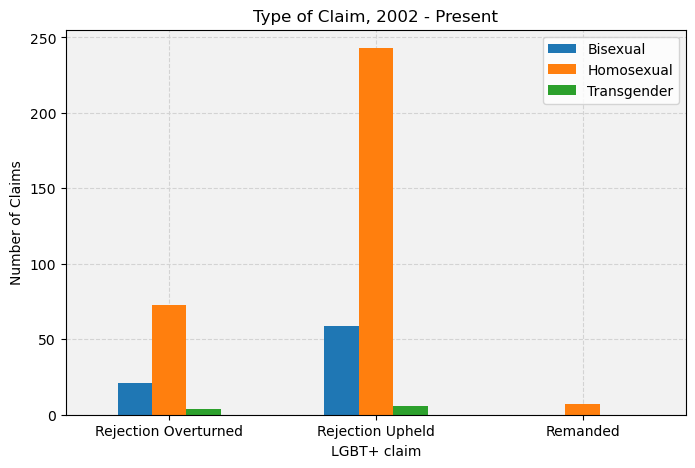

In [33]:
#outcome - sogie sub-group
out_type = df[['text', 'sogie', 'outcome']]
out_type = out_type.groupby(['outcome', 'sogie']).count().reset_index()

ot = out_type.pivot(columns='sogie', index='outcome', values='text')
ax = ot.plot.bar(figsize=(8,5))
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgrey', linestyle='dashed')
ax.xaxis.grid(color='lightgrey', linestyle='dashed')
ax.set_facecolor('#F2F2F2')
ax.set_title('Type of Claim, 2002 - Present')
ax.legend(loc='upper right')
plt.xticks(rotation = 0)
ax.set_xlabel('LGBT+ claim', fontsize = 10)
ax.set_ylabel('Number of Claims', fontsize= 10)

In [ ]:
#Combining gender and sogie
df.loc[(df['sogie'] == 'homosexual') & (df['gender'] == 'man'), 'cat'] = 'gay_man'
df.loc[(df['sogie'] == 'homosexual') & (df['gender'] == 'woman'), 'cat'] = 'lesbian'

df.loc[(df['sogie'] == 'bisexual') & (df['gender'] == 'man'), 'cat'] = 'bi_man'
df.loc[(df['sogie'] == 'bisexual') & (df['gender'] == 'woman'), 'cat'] = 'bi_woman'

df.loc[(df['sogie'] == 'transgender') & (df['gender'] == 'man'), 'cat'] = 'trans'
df.loc[(df['sogie'] == 'transgender') & (df['gender'] == 'woman'), 'cat'] = 'trans'

Text(0, 0.5, 'Number of Claims')

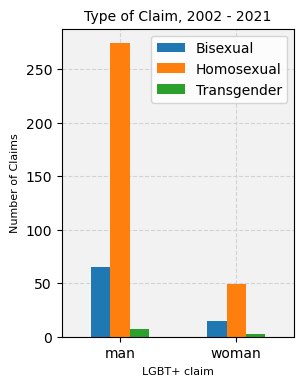

In [40]:
#Gender, sogie sub-group
gender_type = df[['text', 'sogie', 'gender']]
gender_type = gender_type.groupby(['gender', 'sogie']).count().reset_index()

gt = gender_type.pivot(columns='sogie', index='gender', values='text')
ax = gt.plot.bar(figsize=(3,4))
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgrey', linestyle='dashed')
ax.xaxis.grid(color='lightgrey', linestyle='dashed')
ax.set_facecolor('#F2F2F2')
ax.set_title('Type of Claim, 2002 - 2021', fontsize = 10)
ax.legend(loc='upper right')
plt.xticks(rotation = 0)
ax.set_xlabel('LGBT+ claim', fontsize = 8)
ax.set_ylabel('Number of Claims', fontsize= 8)


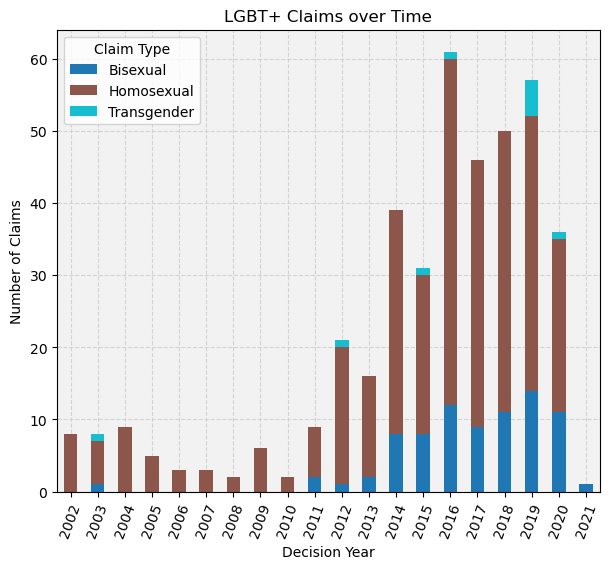

In [42]:
df_cat_year_outcome = df.groupby(['decision_year', 'sogie', 'outcome']).size().reset_index(name='count')

# Pivot the data to create a table
pivot_df = df_cat_year_outcome.pivot_table(index='decision_year', columns='sogie', values='count', aggfunc='sum', fill_value=0)

# Plot the transposed data as a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(7, 6), colormap='tab10')
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgrey', linestyle='dashed')
ax.xaxis.grid(color='lightgrey', linestyle='dashed')
ax.set_facecolor('#F2F2F2')
ax.set_title('LGBT+ Claims over Time')
ax.legend(title='Claim Type', loc='upper left')
plt.xticks(rotation=70)
ax.set_xlabel('Decision Year', fontsize=10)
ax.set_ylabel('Number of Claims', fontsize=10)


plt.savefig('Types_type.png', dpi =600)
plt.show()

## Comparing sogie claims to the general grant rate

In [45]:
# Load df2 from the specified path
df2_path = r"path"
df2 = pd.read_pickle(df2_path)
df2 = df2.rename(columns={'year': 'decision_year'})

# Calculate the total number of outcomes per 'decision_year' in df2
total_counts_df2 = df2.groupby('decision_year')['outcome'].count()

# Calculate the count of 'rejection overturned' outcomes per 'decision_year' in df2
rejection_overturned_counts_df2 = df2[df2['outcome'] == 'Rejection Overturned'].groupby('decision_year')['outcome'].count()

# Calculate percentage of 'Rejection Overturned' for df2
overall_percentage_df2 = (rejection_overturned_counts_df2 / total_counts_df2) * 100

# Convert to DataFrame for easier manipulation
overall_percentage_df2_df = overall_percentage_df2.reset_index(name='overall_percentage')

In [46]:
df2.shape

(15057, 22)

In [80]:
# Calculate the total number of outcomes per 'decision_year' and 'sogie' in df
total_counts_df = df.groupby(['decision_year', 'sogie'])['outcome'].count().reset_index(name='total_count')

# Calculate the count of 'rejection overturned' outcomes per 'decision_year' and 'sogie' in df
rejection_overturned_counts_df = df[df['outcome'] == 'Rejection Overturned'].groupby(['decision_year', 'sogie'])['outcome'].count().reset_index(name='rejection_overturned_count')

# Merge the counts into a single DataFrame
merged_df = pd.merge(total_counts_df, rejection_overturned_counts_df, on=['decision_year', 'sogie'], how='left')#.fillna(0)

# Calculate percentage of 'Rejection Overturned' for each 'sogie' in df
merged_df['percentage'] = (merged_df['rejection_overturned_count'] / merged_df['total_count']) * 100

# Pivot the DataFrame to get a separate column for each 'sogie' value
df_percentage_by_sogie = merged_df.pivot(index='decision_year', columns='sogie', values='percentage').reset_index()

In [84]:
# Merge the percentages from df and df2
combined_df = pd.merge(df_percentage_by_sogie, overall_percentage_df2_df, on='decision_year', how='left')
combined_df


,decision_year,Bisexual,Homosexual,Transgender,overall_percentage
0,2002,NaN,25.000000,NaN,12.616822
1,2003,NaN,50.000000,NaN,16.816431
2,2004,NaN,NaN,NaN,10.968921
3,2005,NaN,60.000000,NaN,11.337868
4,2006,NaN,NaN,NaN,10.915493
5,2007,NaN,NaN,NaN,12.195122
6,2008,NaN,50.000000,NaN,17.695473
7,2009,NaN,NaN,NaN,16.981132
8,2010,NaN,NaN,NaN,22.049689
9,2011,NaN,28.571429,NaN,26.946108


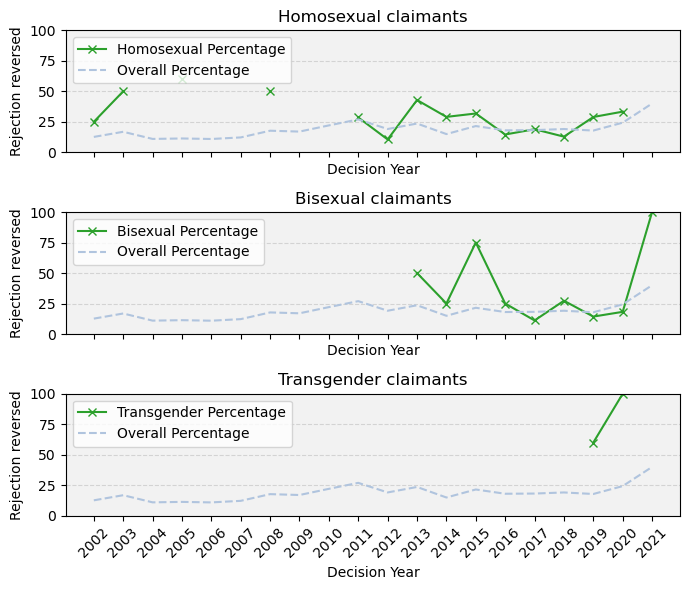

In [89]:

# Ensure 'decision_year' is in integer format
combined_df['decision_year'] = combined_df['decision_year'].astype(str)

# Define colors
sogie_color = 'tab:green'
overall_color = 'lightsteelblue'

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)

# Define sogie categories for each subplot
sogie_categories = ['Homosexual', 'Bisexual', 'Transgender']

# Loop through each sogie category and create a subplot
for i, sogie in enumerate(sogie_categories):
    ax = axes[i]
    
    # Plot the sogie percentage line
    ax.plot(combined_df['decision_year'], combined_df[sogie], color=sogie_color, label=f'{sogie.capitalize()} Percentage', marker='x')    
    # Plot the overall percentage line
    ax.plot(combined_df['decision_year'], combined_df['overall_percentage'], color=overall_color, linestyle='--', label='Overall Percentage')
    
    # Set titles and labels
    ax.set_title(f'{sogie.capitalize()} claimants')
    ax.set_xlabel('Decision Year')
    ax.set_ylabel('Rejection reversed')
    ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    ax.set_facecolor('#F2F2F2')
    ax.legend(loc='upper left')
    
    ax.set_ylim(0, 100)

# Set x-ticks to be the years
axes[-1].set_xticks(combined_df['decision_year'])
axes[-1].set_xticklabels(combined_df['decision_year'], rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('rejection_overturned_comparison.png', dpi=600)
plt.show()


In [63]:
combined_df

,decision_year,Bisexual,Homosexual,Transgender,overall_percentage
0,2002,0.000000,25.000000,0.0,12.616822
1,2003,0.000000,50.000000,0.0,16.816431
2,2004,0.000000,0.000000,0.0,10.968921
3,2005,0.000000,60.000000,0.0,11.337868
4,2006,0.000000,0.000000,0.0,10.915493
5,2007,0.000000,0.000000,0.0,12.195122
6,2008,0.000000,50.000000,0.0,17.695473
7,2009,0.000000,0.000000,0.0,16.981132
8,2010,0.000000,0.000000,0.0,22.049689
9,2011,0.000000,28.571429,0.0,26.946108
